
The inventory code records this information:
* file name
* file location - This is the folder path where the file lives.
* file extension - This is the part of the filename after the period, such as "PDF" or "docx".
* file format - This is the two-part MIME Type for the file. (More detail to follow)
* file size - This is the size of the file in bytes.
* modification timestamp - The date and time of the last time this file was modified.

In [1]:
import os
from os.path import join, getsize, getmtime
import datetime
import csv
import mimetypes

accession_dir = "X:\school\data\Govdocs1-threads"

# function to identify file extension
def get_extension(name):
    result = None
    i = name.rfind('.')
    if i > 0:
        result = name[i+1:]
    return result

# TODO Find another sample folder that is more office docs..

file_count = 0
with open('inventory.csv', 'w', newline='') as csvfile:
    mywriter = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    mywriter.writerow(['name', 'path', 'bytes', 'modified', 'mod_year','extension', 'category', 'mimetype', 'folder1', 'folder2'])
    
    # This is where the "crawl" of files starts, using the Python os.walk() function
    for folder, subfolders, files in os.walk(accession_dir):
        # Walk gives us the folder name (folder), subfolders list, and file names list for each folder in our accession.
        for name in files:
            file_count = file_count + 1  # Count this file
            fullpath = join(folder, name)  # The full path to a file is made by joining file name and folder name.
            
            mod_dt = datetime.datetime.fromtimestamp(getmtime(fullpath))  # modified timestamp is converted into a Python date
            
            (mime, encoding) = mimetypes.guess_type(fullpath)  # Python mimetypes module will guess a mimetype
            if mime is None:
                mime = "application/octet-stream"  # This is a generic "stream of bytes" mimetype
            category = mime.split('/')[0]  # The high-level mimetype is the half before the slash '/', such as 'text' or 'image'
            
            folder_path = folder[len(accession_dir):]  # We trim off the accession folder path to get just the path within the accession.
            path_segments = folder_path.split('/')
            folder1 = path_segments[0]
            folder2 = path_segments[1] if len(path_segments) > 1 else '.'
            
            mywriter.writerow([name, folder_path,  # This writes a line to the CSV file 
                               getsize(fullpath), 
                               mod_dt.isoformat(),
                               mod_dt.year,
                               get_extension(name),
                               category,
                               mime,
                               folder1,
                               folder2])
print("Inventory done: "+accession_dir)
print("Inventory file count:"+str(file_count))

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\me\AppData\Local\Temp\ipykernel_17908\1712930516.py:7: SyntaxWarning: invalid escape sequence '\s'
  accession_dir = "X:\school\data\Govdocs1-threads"


Inventory done: X:\school\data\Govdocs1-threads
Inventory file count:9876


## Inspect the Raw Inventory CSV
After you execute the file inventory code above, you will see a new CSV file in your notebook directory. If you like, you can open that inventory CSV file in Jupyter, which will display it in tabular form. The next block of code will display the first few lines of the file as raw text.

In [2]:
with open('inventory.csv', 'r') as csvfile:
    lines = ''
    for x in range(0,6):
        lines = lines + csvfile.readline()
print(lines)

name,path,bytes,modified,mod_year,extension,category,mimetype,folder1,folder2
837083.jpg,\837,126197,2007-08-04T00:09:11,2007,jpg,image,image/jpeg,\837,.
837352.gif,\837,10222,2001-07-12T06:21:07,2001,gif,image,image/gif,\837,.
837447.jpg,\837,1007134,2002-10-24T10:37:46,2002,jpg,image,image/jpeg,\837,.
837467.jpg,\837,6654,2005-06-08T15:26:33,2005,jpg,image,image/jpeg,\837,.
837565.jpg,\837,1545812,2001-07-12T02:52:52,2001,jpg,image,image/jpeg,\837,.



You can see above that the first line of the CSV file is made up of column names. The data then follows, row by row.

Next we will load the same CSV data into a Python data science tool called Pandas. This means that Python will read your file into a Pandas "data frame" object that we will use going forward. Data frame objects hold tabular data for further processing and display. We will first print the same first few rows of data to give you a sense of how it is organized and let you see that it is working properly. We will also call the shape() function on the data frame object, which gives us the exact dimensions (row and columns) in the data frame.

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('inventory.csv')

display(df.head())
print('dimensions: '+ str(df.shape))

,name,path,bytes,modified,mod_year,extension,category,mimetype,folder1,folder2
0,837083.jpg,\837,126197,2007-08-04T00:09:11,2007,jpg,image,image/jpeg,\837,.
1,837352.gif,\837,10222,2001-07-12T06:21:07,2001,gif,image,image/gif,\837,.
2,837447.jpg,\837,1007134,2002-10-24T10:37:46,2002,jpg,image,image/jpeg,\837,.
3,837467.jpg,\837,6654,2005-06-08T15:26:33,2005,jpg,image,image/jpeg,\837,.
4,837565.jpg,\837,1545812,2001-07-12T02:52:52,2001,jpg,image,image/jpeg,\837,.


dimensions: (9876, 10)


## Visualize Files by their Media Type
Our next step is to visualize the file format information in aggregate, so that we can make preservation decisions. Here we look at a summary of the media types using a standard called the IANA MIME type. IANA MIME types have a type and a subtype, separated by a slash (/) character.

    type/subtype
    
For example, these are some common MIME types:

    image/jpeg
    text/plain
    application/pdf
    
Sometimes MIME types are longer and more complex. Here you can see the difference between older MS Word documents and the more recent .docx documents:

    application/msword
    application/vnd.openxmlformats-officedocument.wordprocessingml.document

In the visualization below the area of each block reflects the number of files of each type and subtype. The color of each block represents the number of bytes stored in each type and subtype. This kind of visualization is called a Treemap and they were first developed in the early 90's by Ben Shneiderman in the Human-Computer Interaction Lab at the University of Maryland's iSchool.

These treemaps are interactive; with some detailed values presented when you hover your pointer on a block and a zoom-in feature when you click on a block.

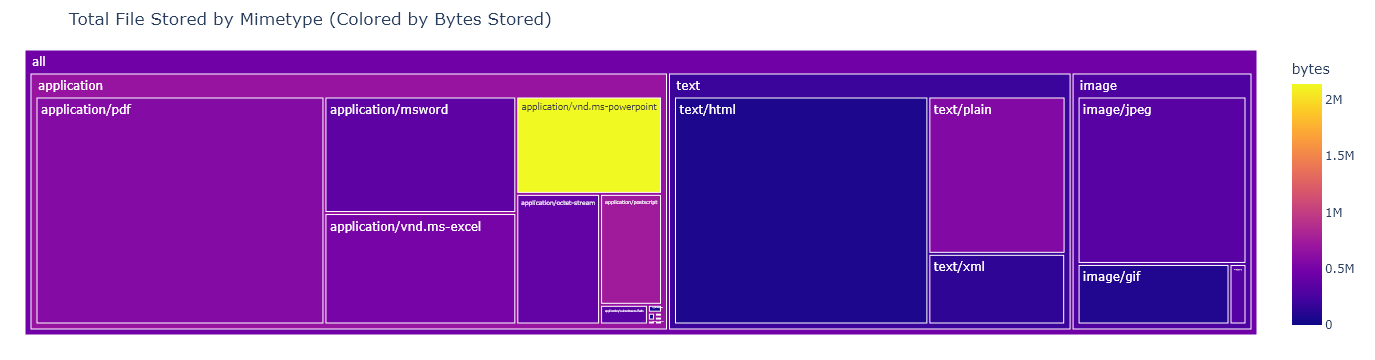

In [17]:
import plotly.express as px

fig = px.treemap(df,
                 title="Total File Stored by Mimetype (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'category', 'mimetype'], 
                 color='bytes',
                 height=500
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Exercise: Mimetype Analysis

Look over the treemap above and notice which types of files are the most common (larger boxes). What conclusions can you draw about this accession based on the common file types? What does the treemap tell us is significant about the PDF files in this accession?

# File Extension vs. Mimetype

A quick look at the same visualization for file extension (the part of the filename after the last dot) shows why we use mimetypes. File extensions are not always informative, whereas at least mimetypes give us a high-level category for each format.

Python's mimetype guessing module is useful for a quick analysis, but there are more sophisticated file format identification tools that you will find helpful. Tools such as Droid and Siegfried (recommended) offer the ability to identify detailed sub-formats for the files in your accessions, such as which version of PDF was used to produce a document. These tools require a fully functional computer with adminitrator access to install and so they are beyond the scope of this notebook demonstration, but they will catch a many more specific formats than Python.

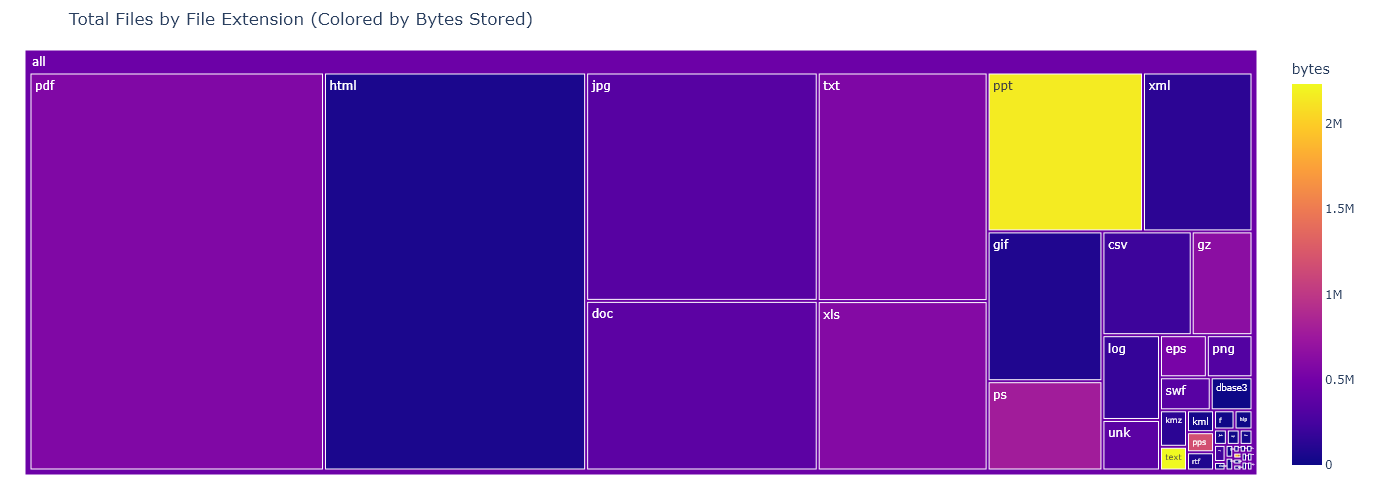

In [19]:
import plotly.express as px

fig = px.treemap(df,
                 title="Total Files by File Extension (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'extension'], 
                 color='bytes',
                 height=500
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Exercise: Comparing File Extensions with Mimetype

The treemap above shows the distribution of files, by area, and bytes, by color, across file extensions. How does it differ from the treemap showing the same distributions across mimetypes? What information is missing?

# Identify Important Folders

This treemap will help you to identify folders that may hold a lot of content or have a special structure, either holding lots of files or very large files. Run the visualization code below and note the way the treemap encoded both of these metrics visually.

Can you identify the folders that contain the most data in terms of bytes? Which folders contain a bunch of smaller files?

In [6]:
import plotly.express as px

fig = px.treemap(df,
                 title="Total Files per Folder (Depth of Two) (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'folder1'], 
                 color='bytes'
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Exercise: Analyzing Folder Structures

People organize files in a variety of ways. Sometimes their folder and sub-folder names are entirely indicative of the content. In other cases, folder names and structures are constrained by the technical considerations of the software tools that either produce or consume the files. As you look at the distribution of files, by area, and bytes, by color, across the top two folder levels what can you see? 

What folder contained the largest files?

Why are there many folders called "www.bop.gov"?

Which folders are named to reflect a person's choices and which seem to be named due to a technical consideration?

## Another View of Folder Structures

As mentioned at the start of this notebook, sometimes folder structures are part of a production workflow for a particular tool is discipline, such as GIS or audiovisual productions, or websites. One way to uncover such structures in larger accessions is to determine the most common folder and file names. Usually folders that are patterned by a workflow will reuse the same folder names or file names. These folder and filename "slots" determine the purpose of the folder or file within the larger workflow.

In the code below we take the "name" column from our data frame and convert the individual names into a shared set of unique categories (`.astype("category")`). Instead of separate text values, the names are now coded as category numbers. So each occurrence of the same name will have the same code. Pandas can then add up the occurrences of each code and give us value counts. (`.value_counts()`) Finally, we call the `head()` function to get just the first 25 most frequent names.

In [7]:
display(df["mimetype"].astype("category").value_counts().head(n=25))

mimetype
application/pdf                                                              2378
text/html                                                                    2117
image/jpeg                                                                   1073
application/msword                                                            807
text/plain                                                                    788
application/vnd.ms-excel                                                      772
application/vnd.ms-powerpoint                                                 512
application/octet-stream                                                      395
text/xml                                                                      353
image/gif                                                                     349
application/postscript                                                        248
image/png                                                                      39
applica

As we look at this list of the most frequent file names in this accession, we can clearly see that the most common file name is index.html, a web page file, with 45 occurances. Next there are some GIF files, usually these are web graphics. Then we have some files called "new.txt", "new.lst", and "readme.txt". It is clues like these that make digital appraisal somewhat of a detective story. You might dive deeper into these files, by reading the files themselves or by researching the file names on the Internet to see what workflows may have produced them.

Depending upon the operating system, files will have a modified date and/or a created date. Usually the modified date is the more significant of these, because it indicates the last edit to a file and may indicate when it was completed or no longer relevant. When transferring files to our own storage we have to be careful to either capture or preserve these dates as metadata.

NOTE: Since this notebook is copied from a Git repository, the sample files included here do not have their original modified date. Since we cannot provide accurately dated files via Git, we are providing some alternative inventory CSV files that were prepared separately.

TODO Differentiate Older and More Recent Folders
TODO: color by average timestamp
TODO: find samples or supply an inventory file better good timestamps..

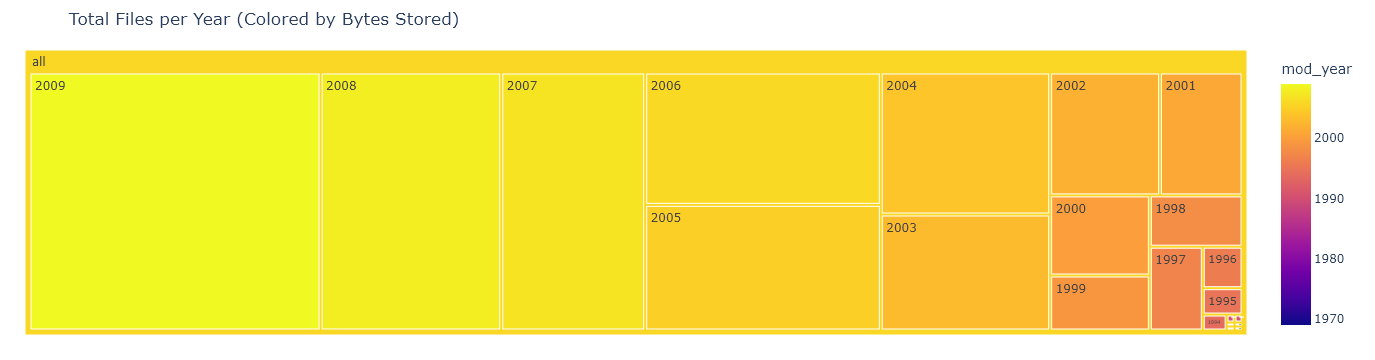

In [20]:
import plotly.express as px

fig = px.treemap(df,
                 title="Total Files per Year (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'mod_year'], 
                 color='mod_year'
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## Dive into Folders
If your initial inventory reveals a sub-folder that is of particular interest, you can run the same visualizations against a specific subfolder. Let's pick a sub-folder and show the mimetype distribution of that subfolder by itself.

The first step is to subset our inventory dataframe, to include only the desired sub-folder.

In [9]:
subfolder_df = df[df['folder1'] == 'Agency History']
subfolder_df.tail()

,name,path,bytes,modified,mod_year,extension,category,mimetype,folder1,folder2


Next we use the same treemap code as our prior mimetype visualization, but supply the new subfolder dataframe.

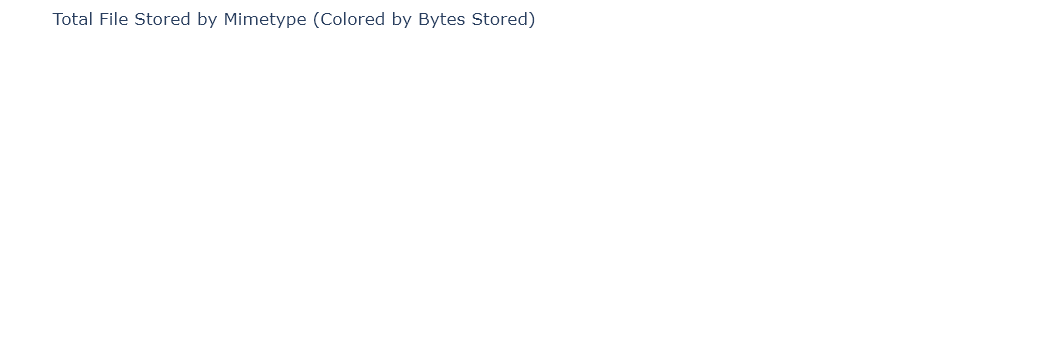

In [21]:
fig = px.treemap(subfolder_df,
                 title="Total File Stored by Mimetype (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'category', 'mimetype'], 
                 color='bytes'
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Exercise: Visualize a Sub-Folder

Pick a different top-level folder and then run a visualization that is limited to that folder. First subset the dataframe as shown above and then use that dataframe to run one of the prior visualizations.

## Looking at a Larger Deposit Inventory

A second and larger set of sample files was inventoried previous and those files are not included with this notebook. However, the inventory file is supplied and you can use it to visual a larger deposit. Below we will load this inventory and visual it with the MIME Type chart.

In [11]:
import pandas as pd
import numpy as np
df173 = pd.read_csv('rg-173-inventory.csv')

print(df173.shape)
df173.head()

(10413, 10)


,name,path,bytes,modified,mod_year,extension,category,mimetype,folder1,folder2
0,spmjc108.txt,Copps/2001,21483,2016-04-06T19:23:18,2016,txt,text,text/plain,Copps,2001
1,spmjc101.txt,Copps/2001,1996,2016-04-06T19:23:16,2016,txt,text,text/plain,Copps,2001
2,spmjc106.txt,Copps/2001,15814,2016-04-06T19:23:17,2016,txt,text,text/plain,Copps,2001
3,spmjc107.html,Copps/2001,16333,2016-04-06T19:23:17,2016,html,text,text/html,Copps,2001
4,spmjc103.doc,Copps/2001,35840,2016-04-06T19:23:17,2016,doc,application,application/msword,Copps,2001


You can see above that this inventory describes 10,413 files, a more challenging quantity for manual appraisal. Now let's run our visualization on this data.

In [12]:
import plotly.express as px

fig = px.treemap(df173,
                 title="Total File Stored by Mimetype (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'category', 'mimetype'], 
                 color='bytes'
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Visualize Larger Deposit Folders

In [13]:
import plotly.express as px

fig = px.treemap(df173,
                 title="Total Files per Folder (Depth of Two) (Colored by Bytes Stored)",
                 path=[px.Constant("all"), 'folder1', 'folder2'], 
                 color='bytes'
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Frequent File Names

Let's reuse our code from the previous example to look over the common file names.

In [14]:
display(df173["name"].astype("category").value_counts().head(n=25))

name
[5]DocumentSummaryInformation    873
[5]SummaryInformation            873
WordDocument                     870
[1]CompObj                       870
1Table                           870
Data                             320
Welcome.html                       4
2001.gif                           4
Current User                       2
PowerPoint Document                2
Pictures                           2
stwek012.html                      2
st970807.html                      2
spsn903.txt                        2
st970807.txt                       2
st970811.html                      2
st970811.txt                       2
2000.gif                           2
1999.gif                           2
1998.gif                           2
spsn903.wp                         2
stgt139.doc                        2
080296.txt                         2
spjhq706.html                      2
stmkp102.txt                       2
Name: count, dtype: int64